In [1]:
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import os
from sklearn.datasets import load_files
import shutil
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
import mglearn
from zipfile import ZipFile

# Logistic Regression for 10 vs. 37 BPs

Several ideas from the code below come from Andreas C. Müller & Sarah Guido

In [2]:
#unzip dataset
if os.path.isdir('decisions') == False:
    ZipFile("decisions.zip").extractall("decisions")

In [3]:
df = pd.read_csv('metadata1037.csv') 
df

,doc_id,publication_time,bp,doc_type,minister
0,20180801_ARE_1089098_314824299,2018-08-01,[10],ARE,rosa weber
1,19700101_Rcl_15658_4390167,1970-01-01,[10],Rcl,ricardo lewandowski
2,19700101_Rcl_10813_3480577,1970-01-01,[10],Rcl,gilmar mendes
3,20181116_Rcl_29884_15339061172,2018-11-16,[10],Rcl,luiz fux
4,20160418_Rcl_22207_309236968,2016-04-18,[10],Rcl,dias toffoli
...,...,...,...,...,...
18640,20180608_Rcl_27063_314542572,2018-06-08,[37],Rcl,dias toffoli
18641,20180608_Rcl_26924_314543852,2018-06-08,[37],Rcl,dias toffoli
18642,20180608_Rcl_27494_314543089,2018-06-08,[37],Rcl,dias toffoli
18643,20180814_ARE_1142843_314981464,2018-08-14,[37],ARE,celso de mello


In [4]:
ids = list(df['doc_id'])
bp_label = list(df['bp'])
bp_set = list(set(df['bp']))
bp_set

['[10, 37]', '[10]', '[37]']

In [5]:
if os.path.isdir('bp1037') == False:
    os.mkdir('bp1037') 
    
if os.path.isdir('bp1037/10') == False:
    os.mkdir('bp1037/10') 
    
    
if os.path.isdir('bp1037/37') == False:
    os.mkdir('bp1037/37') 

In [6]:
for index in range(len(ids)):
    if bp_label[index] == '[10]':
        string = 'decisions/decisions/'+ids[index]+'.txt'
        shutil.copyfile(string, 'bp1037/10/'+ids[index]+'.txt')
    elif bp_label[index] == '[37]':
        string = 'decisions/decisions/'+ids[index]+'.txt'
        shutil.copyfile(string, 'bp1037/37/'+ids[index]+'.txt')

In [7]:
bp_10_37 = load_files("bp1037")
bp_train, label_train = bp_10_37.data, bp_10_37.target
print("type of text_train: {}".format(type(bp_train)))
print("length of text_train: {}".format(len(bp_train)))
print("text_train[1]:\n{}".format(bp_train[1].decode("utf-8")))

type of text_train: <class 'list'>
length of text_train: 17879
text_train[1]:
DECISÃO

RECLAMAÇÃO. AGRAVO DE INSTRUMENTO DE DECISÃO QUE NÃO ADMITE RECURSO ESPECIAL. NECESSIDADE DE JUNTADA DO COMPROVANTE DO PAGAMENTO DE PORTE DE REMESSA E RETORNO. ACÓRDÃO RECLAMADO QUE RECONHECE A DEFICIÊNCIA NA FORMAÇÃO DO AGRAVO DE INSTRUMENTO EM OBSERVÂNCIA AO ART. 511 DO CÓDIGO DE PROCESSO CIVIL E À SÚMULA N. 187 DO SUPERIOR TRIBUNAL DE JUSTIÇA. INCIDÊNCIA DO ART. 544 DO CÓDIGO DE PROCESSO CIVIL NÃO AFASTADA. ALEGADO DESCUMPRIMENTO DA SÚMULA VINCULANTE N. 10 DO SUPREMO TRIBUNAL FEDERAL NÃO CONFIGURADO. RECLAMAÇÃO À QUAL SE NEGA SEGUIMENTO.

Relatório

1. Reclamação, sem pedido de medida liminar, ajuizada por Maristela Jesus da Silva, em 4.11.2009, contra ato da Terceira Turma do Superior Tribunal de Justiça que, nos autos do Agravo de Instrumento n. 927.811/DF, teria descumprido a Súmula Vinculante n. 10 do Supremo Tribunal Federal.

O caso

2. Em 27.8.2009, o Relator do Agravo de Instrumento n. 927

In [8]:
def numeric_masker(dataset):
    '''Substitues all integers in a text dataset by an empty string
    Input: dataset made of texts
    Output: the same dataset made of texts, only with masked integers'''
    masked_set = []
    for index in range(len(dataset)):
        new_string = ''
        for word in range(len(dataset[index])):
            if dataset[index][word].isnumeric()==False:
                new_string += dataset[index][word]
            else:
                new_string += ''
        masked_set.append(new_string)
    return masked_set

In [9]:
#balances dataset to have same number of bps 10 and 37
bp_10 = [bp_train[index] for index in range(len(label_train)) if label_train[index]==0]
print(len(bp_10),'    ', list(label_train).count(0))

#choose randomly from bp 10 same number elements as bp 37
random_indexes = np.random.permutation(len(bp_10))
bp_10_bal = [bp_10[index] for index in random_indexes[:list(label_train).count(1)]]
print(len(bp_10_bal),'    ', list(label_train).count(1))

#produces the balanced set
bp_37 = [bp_train[index] for index in range(len(label_train)) if label_train[index]==1]
bp_train_bal = bp_10_bal+bp_37
bp_train_bal = np.array(bp_train_bal)
label_train_bal = list(np.zeros(len(bp_10_bal)))+list(np.ones(len(bp_37)))
label_train_bal = np.array(label_train_bal)
print(len(bp_train_bal),'    ', len(label_train_bal))

14661      14661
3218      3218
6436      6436


In [10]:
uft_dataset = [bp_train_bal[index].decode("utf-8") for index in range(len(bp_train_bal))]

masked_dataset = numeric_masker(uft_dataset)
masked_dataset[0]

'Decisão:\n\nVistos.\n\nCuida-se de reclamação constitucional eletrônica, com pedido de liminar, ajuizada pela Universidade de São Paulo – USP em face do Juízo da ª Vara do Trabalho de Santos, cuja decisão teria afrontado a autoridade do Supremo Tribunal Federal e a eficácia do que decidido no julgamento da ADC nº /DF.\n\nNa peça vestibular, alega a reclamante que:\n\na) na origem, cuida-se de reclamação trabalhista movida por Jatnael da Silva Tomaz em face da empresa Corporação Gutty de Segurança Patrimonial e Vigilância Ltda, da Fazenda Pública do Estado de São Paulo e desta reclamante, pleiteando verbas trabalhistas referentes ao período laborado na aludida empresa;\n\nb) a ª Vara do Trabalho de Santos “(...) afastou e declarou, por vias transversas, inconstitucional o §º do art.  da Lei federal ./ – em total afronta à autoridade da decisão do Supremo Tribunal Federal, que declarou constitucional referido parágrafo no julgamento da ADC  em // (publicada no D.J.E. e no D.O.U. em //) 

In [11]:
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(masked_dataset, label_train_bal)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

C:\Users\hlovi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hlovi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\hlovi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hlovi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best cross-validation score: 0.98


C:\Users\hlovi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# transform the training dataset
X_train = vectorizer.transform(masked_dataset)
# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names())

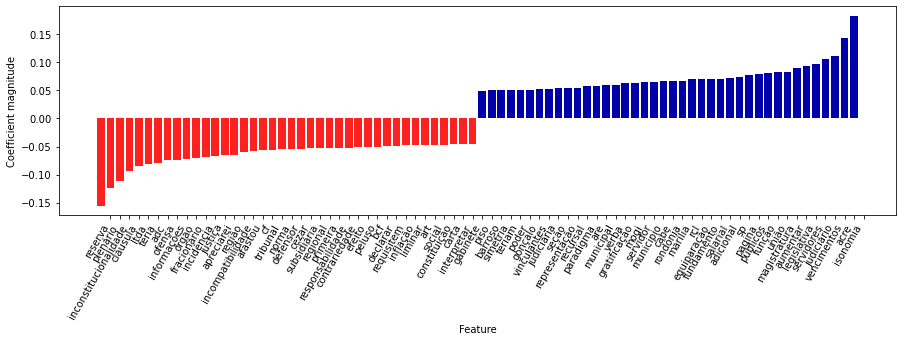

In [13]:
mglearn.tools.visualize_coefficients(
grid.best_estimator_.named_steps["logisticregression"].coef_,
feature_names, n_top_features=40)

Súmula Vinculante 10: Viola a cláusula de reserva de plenário (CF, artigo 97) a decisão de órgão fracionário de tribunal que, embora não declare expressamente a inconstitucionalidade de lei ou ato normativo do Poder Público, afasta sua incidência, no todo ou em parte.

Súmula Vinculante 37: Não cabe ao Poder Judiciário, que não tem função legislativa, aumentar vencimentos de servidores públicos sob o fundamento de isonomia

In [14]:
#deletes extra folder for splitting the dataset
shutil.rmtree('bp1037')

# One vs. All Regression for BPs

In [15]:
#unzip dataset
if os.path.isdir('decisions_allbps') == False:
    ZipFile("decisions_allbps.zip").extractall("decisions_allbps")

In [16]:
df = pd.read_csv('metadata.csv') 
df

,doc_id,publication_time,bp,doc_type,minister
0,19700101_ACO_1646_3420566,1970-01-01,[10],ACO,joaquim barbosa
1,19700101_AC_2287_3093972,1970-01-01,[4],AC,ellen gracie
2,19700101_AC_2459_3245342,1970-01-01,[3],AC,cármen lúcia
3,19700101_AC_2459_3258903,1970-01-01,[3],AC,cármen lúcia
4,19700101_AC_2507_3270033,1970-01-01,[17],AC,joaquim barbosa
...,...,...,...,...,...
29738,20181219_Rcl_31921_15339279527,2018-12-19,"[10, 37]",Rcl,gilmar mendes
29739,20181219_Rcl_32262_15339279531,2018-12-19,[10],Rcl,gilmar mendes
29740,20181219_Rcl_32695_15339271501,2018-12-19,[14],Rcl,rosa weber
29741,20181219_Rcl_32813_15339276760,2018-12-19,[10],Rcl,edson fachin


In [17]:
ids = list(df['doc_id'])
minister = list(df['minister'])
bp_label = list(df['bp'])
bp_set = list(set(df['bp']))
bp_set_single_bp = [element for element in bp_set if len(element)<5]
bp_set_single_bp

['[37]', '[4]', '[17]', '[33]', '[26]', '[11]', '[20]', '[3]', '[14]', '[10]']

In [18]:
if os.path.isdir('allbp') == False:
    os.mkdir('allbp') 
    
if os.path.isdir('allbp/3') == False:
    os.mkdir('allbp/3') 
    
if os.path.isdir('allbp/33') == False:
    os.mkdir('allbp/33') 

if os.path.isdir('allbp/37') == False:
    os.mkdir('allbp/37')

if os.path.isdir('allbp/4') == False:
    os.mkdir('allbp/4') 
    
if os.path.isdir('allbp/14') == False:
    os.mkdir('allbp/14') 
    
if os.path.isdir('allbp/17') == False:
    os.mkdir('allbp/17') 
    
if os.path.isdir('allbp/26') == False:
    os.mkdir('allbp/26') 

if os.path.isdir('allbp/20') == False:
    os.mkdir('allbp/20') 
    
if os.path.isdir('allbp/10') == False:
    os.mkdir('allbp/10') 

if os.path.isdir('allbp/11') == False:
    os.mkdir('allbp/11') 

In [19]:
for index in range(len(ids)):
    string = 'decisions_allbps/decisions/'+ids[index]+'.txt'
    if bp_label[index] == '[3]':
        shutil.copyfile(string, 'allbp/3/'+ids[index]+'.txt')
    elif bp_label[index] == '[33]':
        shutil.copyfile(string, 'allbp/33/'+ids[index]+'.txt')
    elif bp_label[index] == '[37]':
        shutil.copyfile(string, 'allbp/37/'+ids[index]+'.txt')
    elif bp_label[index] == '[4]':
        shutil.copyfile(string, 'allbp/4/'+ids[index]+'.txt')
    elif bp_label[index] == '[14]':
        shutil.copyfile(string, 'allbp/14/'+ids[index]+'.txt')
    elif bp_label[index] == '[17]':
        shutil.copyfile(string, 'allbp/17/'+ids[index]+'.txt')
    elif bp_label[index] == '[26]':
        shutil.copyfile(string, 'allbp/26/'+ids[index]+'.txt')
    elif bp_label[index] == '[20]':
        shutil.copyfile(string, 'allbp/20/'+ids[index]+'.txt')
    elif bp_label[index] == '[10]':
        shutil.copyfile(string, 'allbp/10/'+ids[index]+'.txt')
    elif bp_label[index] == '[11]':
        shutil.copyfile(string, 'allbp/11/'+ids[index]+'.txt')

In [20]:
bp = load_files("allbp")
bp_train, label_train = bp.data, bp.target
print("type of text_train: {}".format(type(bp_train)))
print("length of text_train: {}".format(len(bp_train)))
print("text_train[1]:\n{}".format(bp_train[1].decode("utf-8")))

type of text_train: <class 'list'>
length of text_train: 28534
text_train[1]:
EMB.DECL. NO MANDADO DE INJUNÇÃO 4.391 DISTRITO FEDERAL

RELATOR : MIN. RICARDO LEWANDOWSKI
EMBTE.(S) :ESTADO DE MATO GROSSO DO SUL 
PROC.(A/S)(ES) :ULISSES SCHWARZ VIANA 
EMBDO.(A/S) :PAULO ROBERTO STANGARLIN FERNANDES 
ADV.(A/S) :JACQUES CARDOSO DA CRUZ 
INTDO.(A/S) :PRESIDENTE DA REPÚBLICA 
ADV.(A/S) :ADVOGADO-GERAL DA UNIÃO 

Trata-se de embargos de declaração opostos pelo Estado de Mato 
Grosso do Sul contra a decisão, proferida em 13/3/2012, que, considerada 
a falta do diploma regulamentador a que se refere o art. 40, § 4º, III, da 
Constituição Federal, concedeu parcialmente a ordem para que o pleito 
de aposentadoria especial da servidora pública impetrante pudesse ser 
analisado pela autoridade administrativa, a quem compete a verificação 
do preenchimento ou não dos requisitos legais, em especial os do art. 57 
da Lei 8.213/1991.

É o breve relatório. Decido.

Bem examinados os autos, verifico que 

In [21]:
label_set = list(set(label_train))
for element in label_set:
    print(element, '---->', list(label_train).count(element))

0 ----> 14429
1 ----> 788
2 ----> 1539
3 ----> 840
4 ----> 1654
5 ----> 766
6 ----> 1052
7 ----> 1038
8 ----> 3089
9 ----> 3339


In [22]:
#take only 760 elements of each bp
bp_train_bal = []
label_train_bal = []

for bp in label_set:
    bp_only = [bp_train[index] for index in range(len(label_train)) if label_train[index]==bp]
    random_indexes = np.random.permutation(len(bp_only))
    bp_only = [bp_only[index] for index in random_indexes[:760]]
    bp_train_bal += bp_only
    label_train_bal += [bp for i in range(len(bp_only))]

In [23]:
uft_dataset = [bp_train_bal[index].decode("utf-8") for index in range(len(bp_train_bal))]

In [24]:
masked_dataset = numeric_masker(uft_dataset)
masked_dataset[0]

'RECLAMAÇÃO . RIO GRANDE DO SUL\n\nRELATORA : MIN. CÁRMEN LÚCIA\nRECLTE.(S) :UNIÃO \nPROC.(A/S)(ES) :ADVOGADO-GERAL DA UNIÃO \nRECLDO.(A/S) :TRIBUNAL SUPERIOR DO TRABALHO \nADV.(A/S) :ADVOGADO-GERAL DA UNIÃO \nINTDO.(A/S) :ROSIMARA MARQUES FLORES \nADV.(A/S) :NOÊMIA SOARES GARCIA \nINTDO.(A/S) :MUNICIPIO DE SANTO ANTONIO DA PATRULHA \nPROC.(A/S)(ES) :PROCURADOR-GERAL DO MUNICÍPIO DE SANTO \n\nANTÔNIO DA PATRULHA \n\nINTDO.(A/S) :ESTADO DO RIO GRANDE DO SUL \nPROC.(A/S)(ES) :PROCURADOR-GERAL DO ESTADO DO RIO \n\nGRANDE DO SUL \n\nDECISÃO\n\nRECLAMAÇÃO. CONSTITUCIONAL. \nRESPONSABILIDADE SUBSIDIÁRIA DA \nADMINISTRAÇÃO. ALEGAÇÃO DE \nDESCUMPRIMENTO DA DECISÃO \nPROFERIDA NA AÇÃO DECLARATÓRIA \nDE CONSTITUCIONALIDADE N.  E DA \nSÚMULA VINCULANTE N.  DO \nSUPREMO TRIBUNAL FEDERAL. \nSOBRESTAMENTO.\n\nRelatório \n\n. Reclamação, com pedido de medida liminar, ajuizada pela União, \nem .., contra decisão proferida pela ª Turma do Tribunal Superior \ndo Trabalho, que, no Recurso Revista n. RR -

In [25]:
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(masked_dataset, label_train_bal)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

C:\Users\hlovi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hlovi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\hlovi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hlovi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best cross-validation score: 0.96


C:\Users\hlovi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# transform the training dataset
X_train = vectorizer.transform(masked_dataset)
# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names())

In [27]:
for bp in range(len(grid.best_estimator_.named_steps["logisticregression"].coef_)):
    test_coef = grid.best_estimator_.named_steps["logisticregression"].coef_[bp]
    idx = np.argpartition(test_coef, -40)[-40:]
    indices = idx[np.argsort((-test_coef)[idx])]
    
    most_important_feature = feature_names[indices]
    print(bp, '---->', most_important_feature)

0 ----> ['adc' 'reserva' 'inconstitucionalidade' 'regional' 'fracionário'
 'plenário' 'cláusula' 'órgão' 'norma' 'art' 'subsidiária' 'região'
 'trabalhistas' 'tribunal' 'justiça' 'ofensa' 'trabalho' 'constituição'
 'município' 'sem' 'normativo' 'afastado' 'afasta' 'epp' 'cf' 'julgamento'
 'responsabilidade' 'declare' 'transportes' 'declarou' 'sul' 'gonçalves'
 'do' 'declarar' 'dispositivo' 'contrariedade' 'ltda' 'incompatibilidade'
 'acórdão' 'tst']
1 ----> ['algemas' 'júri' 'uso' 'audiência' 'comarca' 'nulidade' 'prisão' 'vara'
 'juíza' 'aranalde' 'algemado' 'manuel' 'requisitório' 'criminal'
 'circunscrição' 'solicitem' 'venceslau' 'da' 'idelos' 'lojistas'
 'shopping' 'luciana' 'transgressão' 'regente' 'marinho' 'arquive' 'leme'
 'avulsa' 'requerido' 'feito' 'carneiro' 'se' 'despacho' 'regularize'
 'geovani' 'juízo' 'petição' 'flagrante' 'escusar' 'damacena']
2 ----> ['acesso' 'criminal' 'inquérito' 'se' 'negado' 'polícia' 'informações'
 'petição' 'defesa' 'autos' 'ministério' 'deleg

# One vs. All Ministers

In [28]:
#remove nan minister entry
ministers_set = list(set(df['minister']))
ministers_set.pop(0)
ministers_set

['alexandre de moraes',
 'ayres britto',
 'celso de mello',
 'teori zavascki',
 'ellen gracie',
 'menezes direito',
 'joaquim barbosa',
 'marco aurélio',
 'cármen lúcia',
 'dias toffoli',
 'rosa weber',
 'ricardo lewandowski',
 'maurício corrêa',
 'luiz fux',
 'luís roberto barroso',
 'eros grau',
 'edson fachin',
 'gilmar mendes',
 'cezar peluso']

In [29]:
for element in ministers_set:
    print(element, '---->',minister.count(element))

alexandre de moraes ----> 791
ayres britto ----> 226
celso de mello ----> 2673
teori zavascki ----> 1363
ellen gracie ----> 427
menezes direito ----> 272
joaquim barbosa ----> 731
marco aurélio ----> 356
cármen lúcia ----> 3129
dias toffoli ----> 3610
rosa weber ----> 3048
ricardo lewandowski ----> 2504
maurício corrêa ----> 1
luiz fux ----> 3251
luís roberto barroso ----> 2209
eros grau ----> 262
edson fachin ----> 1787
gilmar mendes ----> 1980
cezar peluso ----> 223


In [30]:
#use only ministers that  have more than 700 citations
ministers_set_copy = ministers_set[:]
for element in ministers_set_copy:
    if minister.count(element)<700:
        ministers_set.remove(element)
ministers_set

['alexandre de moraes',
 'celso de mello',
 'teori zavascki',
 'joaquim barbosa',
 'cármen lúcia',
 'dias toffoli',
 'rosa weber',
 'ricardo lewandowski',
 'luiz fux',
 'luís roberto barroso',
 'edson fachin',
 'gilmar mendes']

In [31]:
#make a folder to store the data
if os.path.isdir('minister') == False:
    os.mkdir('minister') 
    
#make a folder for each limit, allowing then to use sklearn.datasets.load_files
for minis in ministers_set:
    if os.path.isdir('minister/'+str(minis)) == False:
        os.mkdir('minister/'+str(minis)) 

In [32]:
for index in range(len(ids)):
    if minister[index] in ministers_set:
        string = 'decisions_allbps/decisions/'+ids[index]+'.txt'
        shutil.copyfile(string, 'minister/'+str(minister[index])+'/'+ ids[index]+'.txt')

In [33]:
ministers = load_files("minister")
#creates train and label sets
minister_train, label_train = ministers.data, ministers.target
print("type of text_train: {}".format(type(minister_train)))
print("length of text_train: {}".format(len(minister_train)))
print("text_train[1]:\n{}".format(minister_train[1].decode("utf-8")))

type of text_train: <class 'list'>
length of text_train: 27076
text_train[1]:
Decisão:

Vistos.

Cuida-se de reclamação constitucional eletrônica, com pedido de liminar, ajuizada pela Universidade de São Paulo – USP em face do Juízo da 2ª Vara do Trabalho de Santos, cuja decisão teria afrontado a autoridade do Supremo Tribunal Federal e a eficácia do que decidido no julgamento da ADC nº 16/DF.

Na peça vestibular, alega a reclamante que:

a) na origem, cuida-se de reclamação trabalhista movida por Jatnael da Silva Tomaz em face da empresa Corporação Gutty de Segurança Patrimonial e Vigilância Ltda, da Fazenda Pública do Estado de São Paulo e desta reclamante, pleiteando verbas trabalhistas referentes ao período laborado na aludida empresa;

b) a 2ª Vara do Trabalho de Santos “(...) afastou e declarou, por vias transversas, inconstitucional o §1º do art. 71 da Lei federal 8.666/93 – em total afronta à autoridade da decisão do Supremo Tribunal Federal, que declarou constitucional referid

In [34]:
label_set = list(set(label_train))
for element in label_set:
    print(element, '---->', list(label_train).count(element))

0 ----> 791
1 ----> 2673
2 ----> 3129
3 ----> 3610
4 ----> 1787
5 ----> 1980
6 ----> 731
7 ----> 3251
8 ----> 2209
9 ----> 2504
10 ----> 3048
11 ----> 1363


In [35]:
#take only 700 elements of each bp
minister_train_bal = []
label_train_bal = []

#balances the dataset so every minister have same representativity
for minis in label_set:
    minister_only = [minister_train[index] for index in range(len(label_train)) if label_train[index]==minis]
    random_indexes = np.random.permutation(len(minister_only)) 
    minister_only = [minister_only[index] for index in random_indexes[:700]] #picks 700 random documents for each minister
    minister_train_bal += minister_only
    label_train_bal += [minis for i in range(len(minister_only))]

In [36]:
#make a list of words to mask
minister_names = [minis.split() for minis in ministers_set]
flat_names = [item for sublist in minister_names for item in sublist]
flat_names += ['carmen', 'luis', 'lucia']
#substitute gender specific words that can be used to relate to some ministers
flat_names += ['relatora', 'relator', 'ministro','ministra','minis', 'turma', 'primeira', 'segunda', 'min']
cap_names = [minis.capitalize() for minis in flat_names]
up_names = [minis.upper() for minis in flat_names]
mask_list = flat_names+cap_names+up_names
#add puntuation to everything
comma_list = [word+',' for word in mask_list]
dot_list = [word+'.' for word in mask_list]
mask_list += comma_list+dot_list
mask_list

['alexandre',
 'de',
 'moraes',
 'celso',
 'de',
 'mello',
 'teori',
 'zavascki',
 'joaquim',
 'barbosa',
 'cármen',
 'lúcia',
 'dias',
 'toffoli',
 'rosa',
 'weber',
 'ricardo',
 'lewandowski',
 'luiz',
 'fux',
 'luís',
 'roberto',
 'barroso',
 'edson',
 'fachin',
 'gilmar',
 'mendes',
 'carmen',
 'luis',
 'lucia',
 'relatora',
 'relator',
 'ministro',
 'ministra',
 'minis',
 'turma',
 'primeira',
 'segunda',
 'min',
 'Alexandre',
 'De',
 'Moraes',
 'Celso',
 'De',
 'Mello',
 'Teori',
 'Zavascki',
 'Joaquim',
 'Barbosa',
 'Cármen',
 'Lúcia',
 'Dias',
 'Toffoli',
 'Rosa',
 'Weber',
 'Ricardo',
 'Lewandowski',
 'Luiz',
 'Fux',
 'Luís',
 'Roberto',
 'Barroso',
 'Edson',
 'Fachin',
 'Gilmar',
 'Mendes',
 'Carmen',
 'Luis',
 'Lucia',
 'Relatora',
 'Relator',
 'Ministro',
 'Ministra',
 'Minis',
 'Turma',
 'Primeira',
 'Segunda',
 'Min',
 'ALEXANDRE',
 'DE',
 'MORAES',
 'CELSO',
 'DE',
 'MELLO',
 'TEORI',
 'ZAVASCKI',
 'JOAQUIM',
 'BARBOSA',
 'CÁRMEN',
 'LÚCIA',
 'DIAS',
 'TOFFOLI',
 'ROSA',

In [39]:
def masker(dataset, list_of_masked):
    '''Substitues words that are in the masked list by an empty string
    Input: dataset made of texts
    Output: the same dataset made of texts, only with masked words'''
    masked_set = []
    for index in range(len(dataset)):
        new_string = ''
        splitted_doc = dataset[index].split()
        for word in range(len(splitted_doc)):
            if splitted_doc[word] in list_of_masked:
                new_string += ''
            else:
                new_string += ' '+ splitted_doc[word]
        masked_set.append(new_string)
    return masked_set

In [40]:
uft_dataset = [minister_train_bal[index].decode("utf-8") for index in range(len(minister_train_bal))]

In [41]:
masked_dataset = masker(uft_dataset, mask_list)
masked_dataset[0]

' RECURSO EXTRAORDINÁRIO COM AGRAVO 1.060.316 SÃO PAULO : RECTE.(S) :MUNICÍPIO PENÁPÓLIS ADV.(A/S) :PROCURADOR-GERAL DO MUNICÍPIO PENÁPOLIS RECDO.(A/S) :ELIZABETHI ANA LIMA SOUZA ADV.(A/S) :MARCO ANTONIO OBA 144042 OAB SP DECISÃO Trata-se agravo decisão que inadmitiu recurso extraordinário interposto contra acórdão do Tribunal Superior do Trabalho. A Corte origem decidiu que ofendem o art. 37, X, da Constituição as sucessivas leis do Município Penápolis que efetuaram a revisão geral anual dos vencimentos dos servidores públicos por meio reajustes em valores fixos, pois tal sistemática acarreta a aplicação índices diferenciados reposição salarial, o que é vedado pela parte final da norma constitucional. O Município interpôs recurso extraordinário ao argumento violação aos arts. 37, X, e 125, parágrafo 2º, da Constituição, bem como desrespeito à Súmula vinculante 37. É o relatório. Decido. Embora já tenha proferido decisões no sentido do desprovimento agravos em casos similares, revisite

In [42]:
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(masked_dataset, label_train_bal)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

C:\Users\hlovi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hlovi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\hlovi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hlovi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best cross-validation score: 0.96


C:\Users\hlovi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# transform the training dataset
X_train = vectorizer.transform(masked_dataset)
# find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names())

In [44]:
for minis in range(len(grid.best_estimator_.named_steps["logisticregression"].coef_)):
    test_coef = grid.best_estimator_.named_steps["logisticregression"].coef_[minis]
    idx = np.argpartition(test_coef, -40)[-40:]
    indices = idx[np.argsort((-test_coef)[idx])]
    
    #shows 40 most important words for deciding belonging to each class
    most_important_feature = feature_names[indices]
    print(minis, '---->', most_important_feature)

0 ----> ['2017' 'interno' 'regimento' '2018' 'amparo' 'diante' 'vol' 'codificação'
 'apelo' 'federal' 'supremo' 'fl' 'pagina' 'extremo' 'doc' 'dje' 'rel'
 'caberá' '988' 'decido' 'recorrido' 'violado' '2015' '85' 'ofendeu'
 'linhas' 'debatida' 'publicado' 'ato' 'precedente' 'iii' 'aplica'
 'julgando' 'circunscrição' 'constitucionais' 'are' 'tendo' 'antes' '88'
 'concentrado']
1 ----> ['grifei' 'presente' 'ora' 'nº' 'enunciado' 'suprema' 'sendo' 'constante'
 'em' 'causa' 'rel' 'versada' 'conseqüência' 'possui' 'transgredido'
 'despacho' 'na' 'sede' 'sumular' 'proferindo' 'deduzida' 'medida'
 'transgressão' 'expostas' 'desautoriza' 'instruído' 'nele' 'df'
 'cautelar' 'questão' 'formulou' 'referência' 'prévias' 'rtj' 'exame'
 'apreciarei' 'questionado' 'parte' 'assim' 'consubstanciado']
2 ----> ['supremo' 'inc' 'tribunal' 'fl' 'república' 'declaratória' 'descumprido'
 'este' 'descumprimento' 'dj' 'havidos' 'agravante' 'contrariado' 'doc'
 'nossos' 'requerimento' 'alegado' '2009' 'assiste'

In [45]:
#deletes extra folder for splitting the dataset
shutil.rmtree('minister')